In this section, we introduce the usage of the extended surface model.  

Catalytic assessment on extended surfaces follows these steps:
- Build the extended surface.
- Predict adsorption energies for all configurations on each atom, generating the gross c.
- Obtain the net adsorption energy distribution via a loop that searches for the most stable sites and masks their neighbors.
- Calculate the final result using an activity prediction function.

In [1]:
from heaict.cats.surface import brute_force_surface, get_activity_selectivity

# Create Extended Surface
First, specify the extended surface size and layers during initialization. We use a small 50x50x3 atom surface here.   

Also, pass in the adsorbate and all (slab and adsorbate) elements and the hyperparameters for the grab_element_feature function (here we use hyperparameters from the literature). Ensure these hyperparameters match those used during your ML model training.

In [3]:
from heaict.para import para_grab_feature

es = brute_force_surface(
    surface_size=(50, 50),
    n_layers=3,
    all_elements=['Mo', 'Mn', 'Fe', 'Ru', 'Co', 'Ni', 'Pd', 'Cu', 'N', 'H'],
    adsorbate_elements=['N', 'H'],
    para_grab_feature=para_grab_feature
)

After defining the surface dimensions, the next step is to assign elemental symbols to the surface atoms. Functions for creating High-Entropy Alloy (HEA) and High-Entropy Intermetallic (HEI) surfaces are implemented in two separate functions:
- **create_slab_HEA**: Creating an HEA surface only requires specifying the compositional proportion of each element to generate the structure randomly.
- **create_slab_HEI**: Creating an HEI surface requires defining the elemental proportion at each site and the criteria for identifying specific site sublattice (e.g., B-sites on A$_3$B$_1$).

For convenience, atomic coordinates on the extended surface are typically represented using their indices in a NumPy matrix. For instance, coordinates in the x and y directions are integers ranging from 0 to 49. Regarding the z-direction, please note that an increasing z-index corresponds to a decrease in layer depth. Specifically, the outermost layer is indexed as 0, and the sub-outermost layer is indexed as 1.

In the B-site identification vector ([[2, 2], [1, 0]]) for the HEI:
- The first half represents the in-plane criteria, meaning that every other atom in the x and y directions is designated as a B-site.
- The second half describes how B-sites change with increasing layers; specifically, the B-site positions shift by one unit in the x-direction relative to the layer above when moving to a deeper layer.  

The specific method for coordinate transformation will be discussed in the following section.


In [5]:
es.create_slab_HEI(
    composition={'A': {'Mo': 0.5, 'Ru': 0.5}, 'B': {'Cu': 1}},
    B_vector=[[2, 2], [1, 0]],
)

In [6]:
es.create_slab_HEA(
    composition={'Ni': 0.2, 'Pd': 0.2, 'Cu': 0.2, 'Mo': 0.2, 'Mn': 0.2}
)

# Load Archetype
As previously mentioned, obtaining the gross adsorption energy distribution of the surface requires predicting the adsorption energy of various configurations at each atomic site.

We load the configurations to be predicted by directly reading VASP structure files. The notes and required inputs are as follows:
- **Structure Files**: These VASP structures represent the N-th nearest neighbor shell of the adsorption site.
- **Reference Atom**: A reference atom must be specified using fractional coordinates. This atom indicates the position of the corresponding surface atom.
- **Coordinate Transformation**: You need to provide the conversion method between fractional coordinates and matrix index coordinates. To facilitate coordinate transformation and surface atom positioning, it is recommended to use un-optimized structures.
- **Feature Generation**: You must also input parameters related to adsorption site identification and graph feature generation. These parameters are used to determine the adsorption site and generate structural features for the graph.  

During prediction, the program uses the reference atom as the origin. It extracts the elemental symbol of the corresponding archetype structure atom to obtain elemental features, which are then overwritten onto the corresponding graph data for prediction.  

We directly use the parameters from the literature for demonstration purposes; these parameters are pre-stored in **para**. Please modify them according to your specific requirements in practical applications.

In [11]:
from heaict.para import zero_frac, grid_basis_in_frac, para_add_feat

In [8]:
zero_frac

(0.4444, 0.4444, 0.3)

In [9]:
grid_basis_in_frac

array([[ 0.1111    ,  0.        ,  0.        ],
       [ 0.        ,  0.1111    ,  0.        ],
       [-0.03703333, -0.07406667, -0.0992    ]])

In [12]:
es.read_archetype(
    file_path=f'Data/Archetype_slab/n3/',
    zero_frac=zero_frac,
    grid_basis_in_frac=grid_basis_in_frac,
    para_constr_graph={},
    para_add_feat=para_add_feat,
    para_infer_site={}
)

# Get gross energy distribution
Obtaining the total adsorption energy only requires inputting a ML model used for energy prediction.   

Please note that the total adsorption energy prediction process relies on the machine learning methods within this library; if you use other models, you will need to make modifications at the code level.

In [13]:
from heaict.ml.mode import GNN
from heaict.para import para_model
import torch

In [14]:
model = GNN(**para_model)
model.load_state_dict(torch.load(f'Data/Model_dict/Model_25107_dict.pt', map_location=torch.device('cuda')))

<All keys matched successfully>

In [16]:
es.eval_gross_energies(
    model=model,
    batch_size=5000
)

Gross energy distribution will be stored for each adsorbate-site pairs on self.gross_energies as an numpy.array with a shape of (number_pairs, nrows, ncolumns)

In [18]:
es.gross_energies.shape

(28, 50, 50)

# Get Net energy distribution
To obtain the net adsorption energy distribution, you need to pass in a reaction step sequence that specifies the search order for the most stable molecules.   

The program will first search for the most stable adsorption site within the first molecule of each reaction step. Subsequently, based on the corresponding reaction step of that molecule, it will sequentially search for the adsorption sites of the remaining molecules within a multifunctional site.  

The length of each reaction step must be consistent; use None to represent a null value. It is also acceptable for each reaction step to contain only one molecule

In [19]:
from heaict.para import reaction_steps

In [20]:
reaction_steps

[['N2', 'NNH', 'NH', 'NH3', 'H'],
 ['NNH', 'N2', 'NH', 'NH3', 'H'],
 ['H', 'N2', 'NNH', 'NH', 'NH3']]

In [22]:
site_adsenergy = es.get_net_energies(reaction_steps=reaction_steps)

"The obtained adsorption energy distributions are one-to-one correspondences; the adsorption energies of different molecules at the same index correspond to the same adsorption site.

In [24]:
site_adsenergy.keys()

dict_keys(['H', 'N2', 'NH', 'NH3', 'NNH'])

In [25]:
site_adsenergy['H'].shape

(593,)

"After obtaining the net adsorption energy distribution, you can calculate the surface coverage (defined as the total number of adsorbed atoms divided by the total number of surface atoms).

In [26]:
es.get_max_coverage()

0.8212

# Get Activity and Selectivity
The NRR activity and selectivity are calculated using a separate function, requiring only the net adsorption energy distribution as input. For different tasks, users need to customize other activity evaluation methods.

In [27]:
from heaict.cats.surface import get_activity_selectivity

In [28]:
v_NRR, v_HER, FE, U_opt = get_activity_selectivity(site_adsenergy)

In [29]:
print(v_NRR, v_HER, FE, U_opt)

0.08632445742722832 0.3344824797178935 0.436381866332778 -0.30000000000000004


In addition, this function can also provide the indices of NRR active sites (where N$_2$ adsorption is stronger than H) at the optimal potential. These indices can be used for subsequent visualization and site statistics.

In [39]:
indices = get_activity_selectivity(site_adsenergy, get_NRR_site_indices_at=U_opt)

# Plot surface
A function is provided to plot a partial or full surface, marking non-boundary adsorption sites.   

Plotting adsorbed molecules is not currently supported.   

You must define the color, size for each element, and the transformation matrix to convert matrix coordinates back to Cartesian coordinates.

In [31]:
from heaict.para import slab_lattice
import matplotlib.pyplot as plt

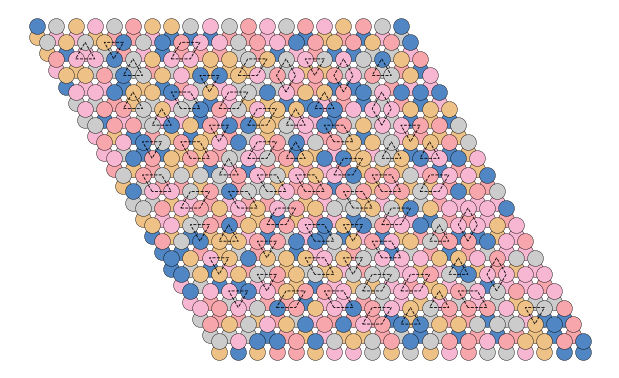

In [38]:
fig=plt.figure(figsize=(6, 4))
ax=fig.add_axes([0,0,1,1])

color_dict = {'Ni': '#CCCCCC', 'Pd': '#5086C4', 'Cu': '#EEC186', 'Mo': '#F7A6AC', 'Mn': '#F7B7D2'}
atomic_vector = grid_basis_in_frac @ slab_lattice
x_range=(37, 50)
y_range=(90, 103)

es.plot_surface(ax=ax, 
                color_dict=color_dict, 
                atomic_vector=atomic_vector, 
                x_range=(10, 30), 
                y_range=(10, 30), 
                n_layers=2, 
                plot_site=True, 
                site_indices=None, # or indices for NRR active sites only
                atom_scatter={'linestyle': '-', 'edgecolor': 'k', 's':130, 'lw':0.3}, 
                site_line={'linestyle': '--', 'color': 'k', 'lw': 0.6})


# Count Sites
Finally, we provide a function to count adsorption sites, which returns the configurations of the sites along with their corresponding counts.   

You can also pass in a set of indices to restrict the counting to specific sites.

For 4-fold sites, their sets represent long and short diagonal element.

In [41]:
es.count_site(grid_vector=atomic_vector, indices=indices) # or None

[([{42}, {25, 42}], 17),
 ([{25, 42}, {25}], 16),
 ([{42}, {25}], 10),
 ([{25, 42}, {25, 42}], 7),
 ([{42}, {42}], 3),
 ([{25}, {42}], 2),
 ([{25}, {25}], 2),
 ([{25}, {25, 42}], 1),
 ([{42, 46}, {25, 42}], 1),
 ([{25, 42}, {25, 28}], 1),
 ([{42}, {25, 28}], 1)]